# Time Delayed Neural Network (TDNN) implemented in PyTorch over NARMA10 task

NARMA10 is a benchmark task for testing the ability of a model to learn long-term dependencies. It is a synthetic time series dataset that is generated by a nonlinear autoregressive moving average model of order 10. The task is to predict the next value of the time series given the previous 10 values. The dataset is generated by the following equation:

$$
y(t) = 0.3y(t-1) + 0.05y(t-1)y(t-10) + 1.5x(t-1)x(t-10) + 0.1
$$

where $y(t)$ is the output at time $t$ and $x(t)$ is the input at time $t$. The input $x(t)$ is a random number between 0 and 0.5. The output $y(t)$ is a function of the previous 10 values of $x(t)$ and $y(t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import data from NARMA10 csv as a single column
data = pd.read_csv('NARMA10.csv', header=None)

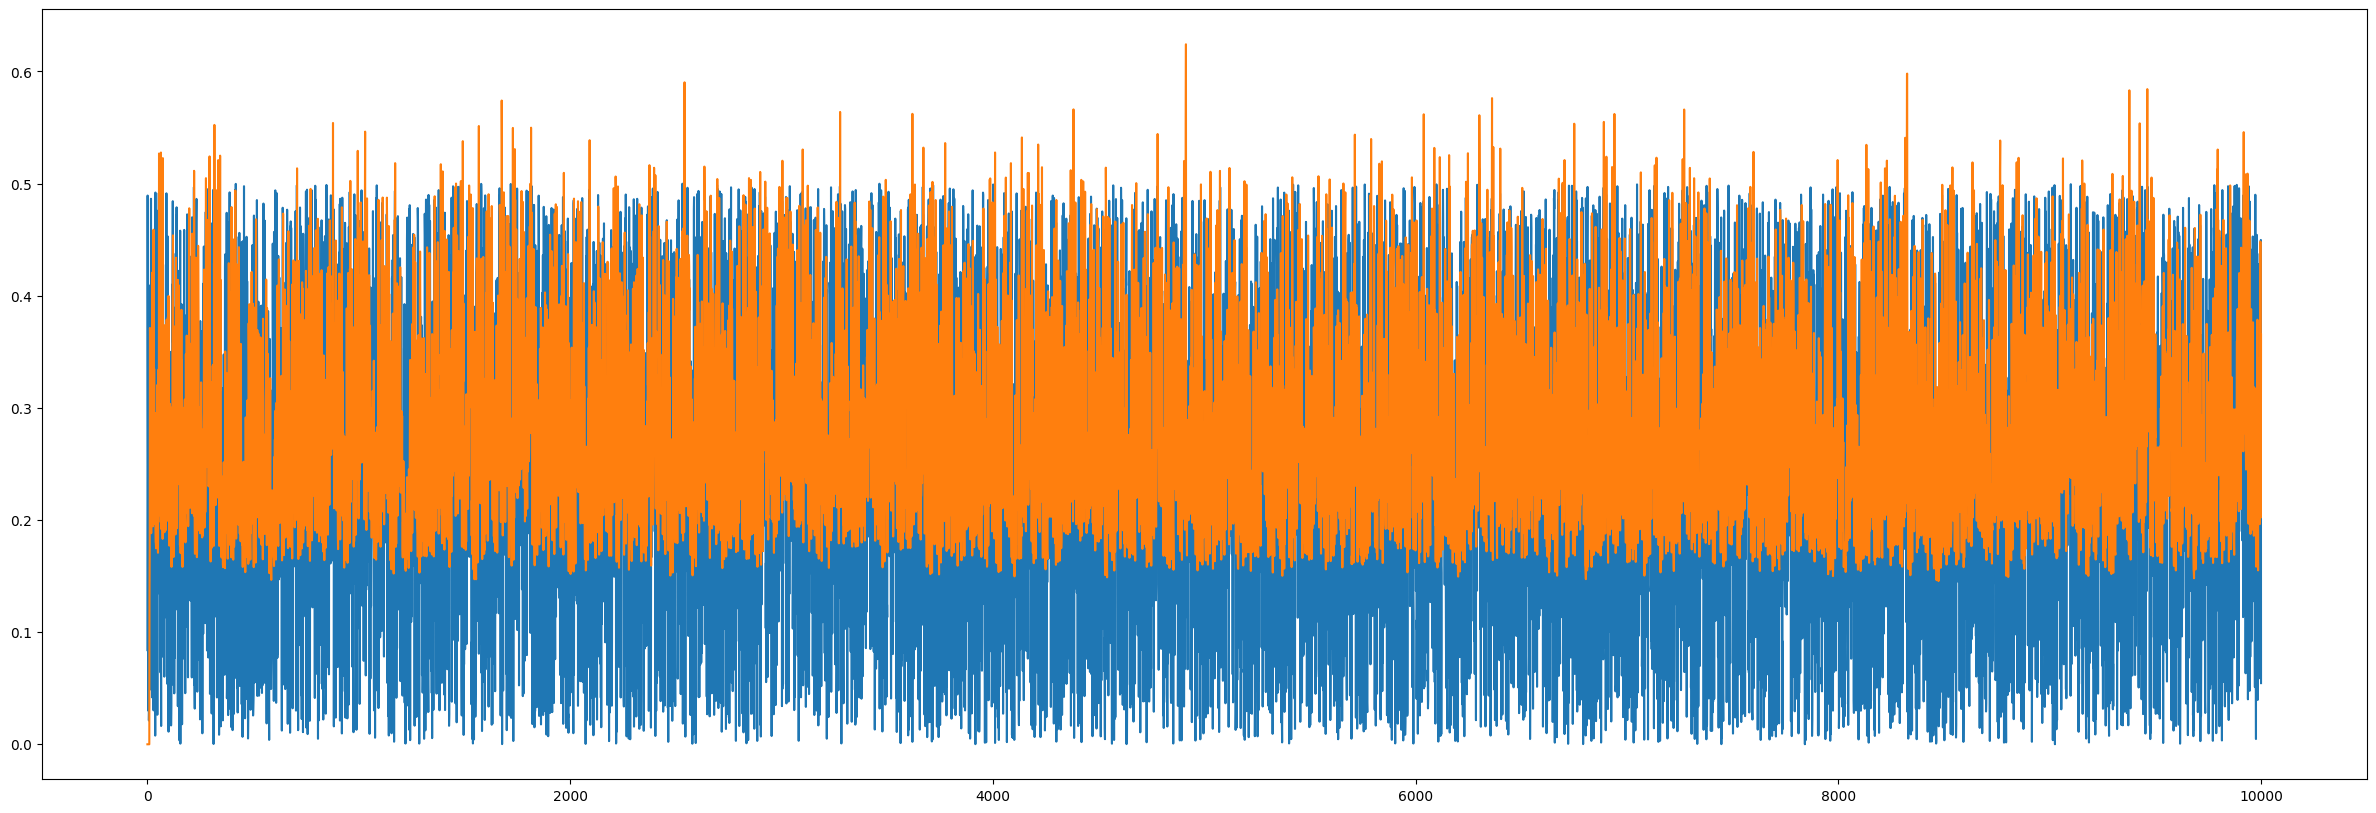

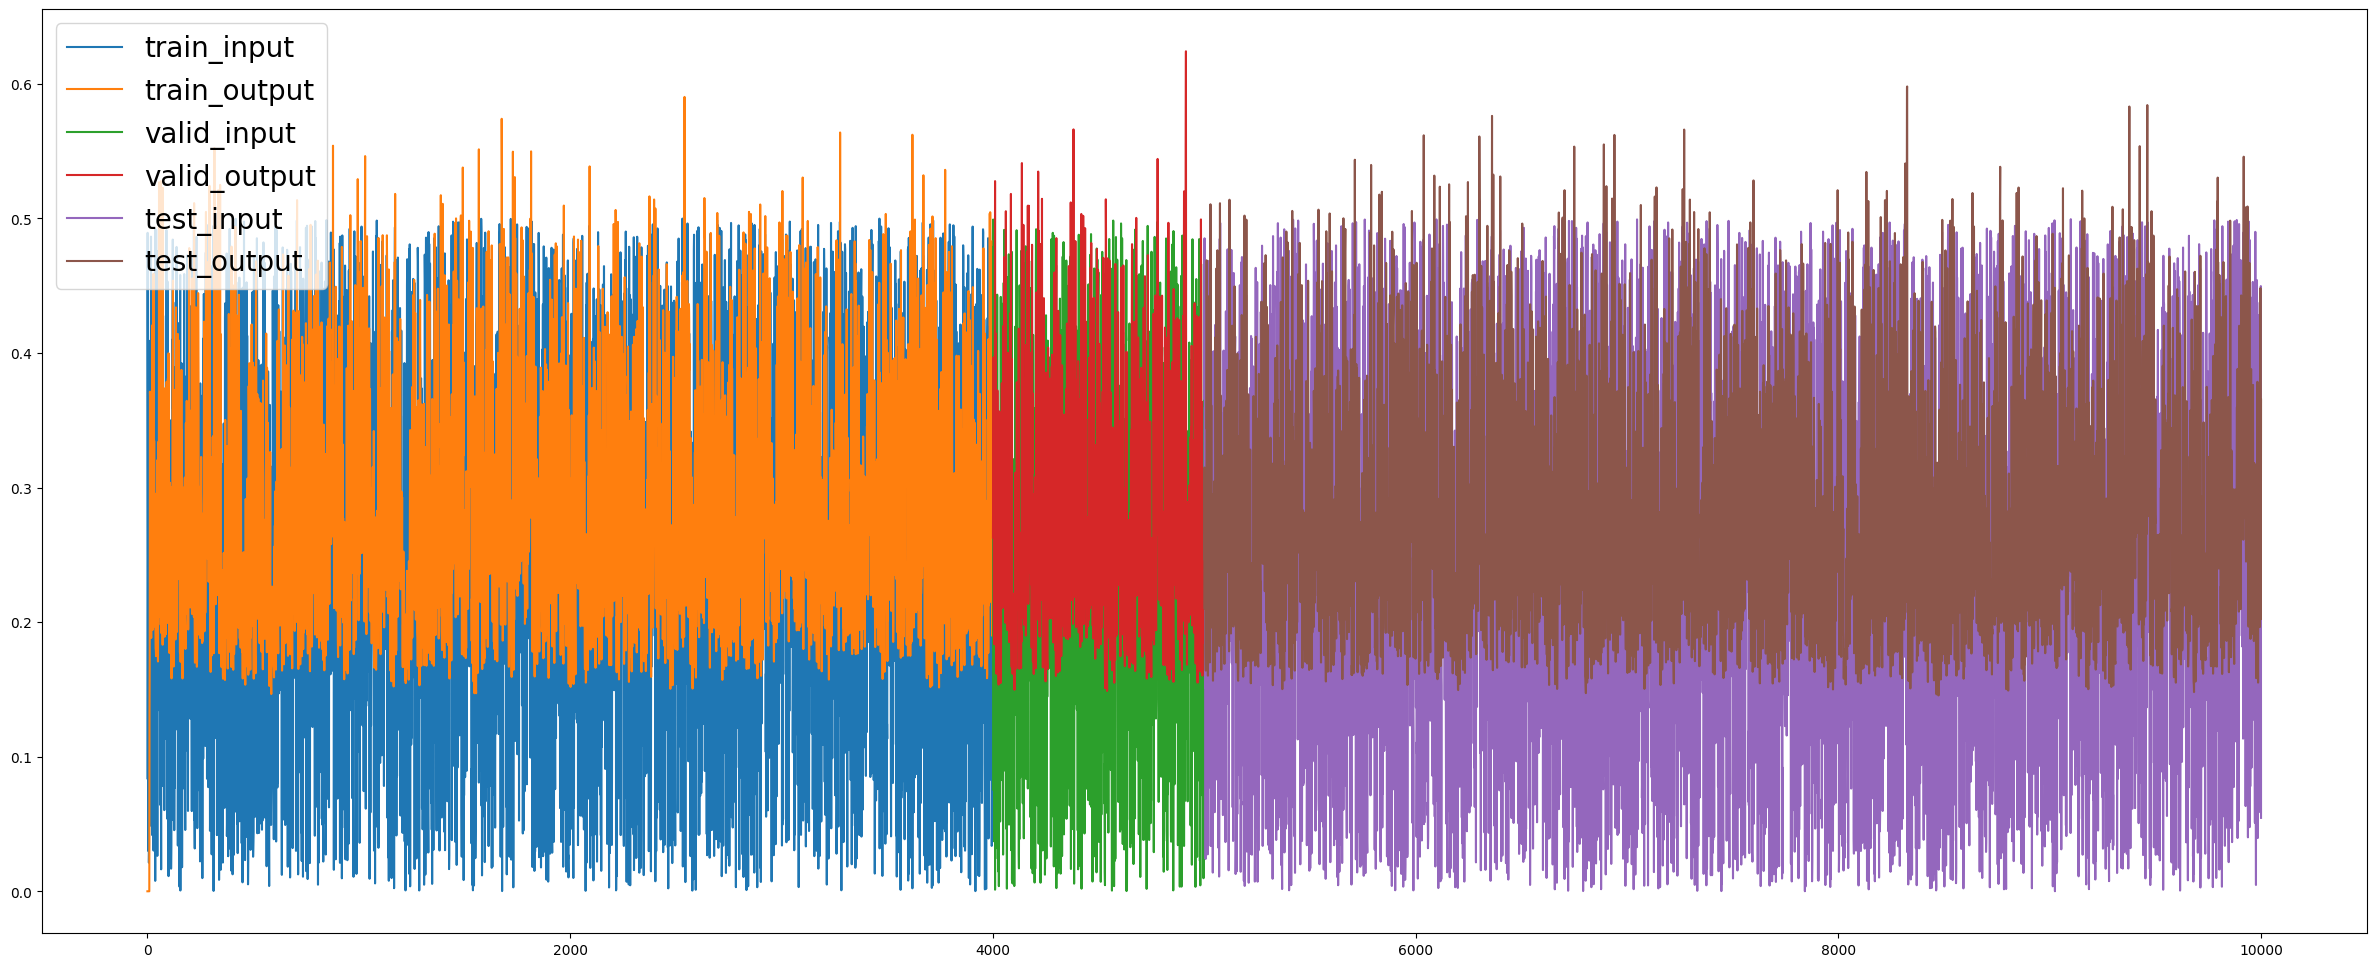

In [3]:
# plot the data in time series format
data.shape

# First row is the input signal x
input_data = data.iloc[0]  
# Second row is the application of y(t) to our x data
output_data = data.iloc[1]

# make larger x-axis
plt.figure(figsize=(30,10))
plt.plot(input_data)

plt.plot(output_data)


# Suggestion on spits: 5000 in developement (4k train, 1k valid) and 5000 in test
# Use the hidden state of the RNN for the valid after train. For the test one can retrain the model with the full dataset 
# and then use the last hidden state for the test. Or use a transient period (at least 10 steps since the NARMA10 
# based on last 10 steps)

# Split the data into train, valid and test
train_input = input_data[:4000]
train_output = output_data[:4000]

valid_input = input_data[4000:5000]
valid_output = output_data[4000:5000]

test_input = input_data[5000:]
test_output = output_data[5000:]

# make copy of the train input and valid to use in the other model
train_input_copy = train_input.copy()
valid_input_copy = valid_input.copy()
test_input_copy = test_input.copy()
train_output_copy = train_output.copy()
valid_output_copy = valid_output.copy()
test_output_copy = test_output.copy()


# plot the data in time series format
plt.figure(figsize=(30,12))
plt.plot(train_input)
plt.plot(train_output)
plt.plot(valid_input)
plt.plot(valid_output)
plt.plot(test_input)
plt.plot(test_output)

# legend
plt.legend(['train_input', 'train_output', 'valid_input', 'valid_output', 'test_input', 'test_output'], loc='upper left', fontsize=20)

In [4]:
train_input.shape

(4000,)

# Best params
- 1 Layer, 50 hidden, 3 dilation, 1 kernel size, 1 stride, 1 padding, 0 dropout, 0 bias

In [5]:
# Some advice on TDNN can use 1D convolutions with kernel size 1.
from tqdm import tqdm
from torch import nn
from TimeDelayNeuralNetwork import *

USE_CUDA = False

if USE_CUDA:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
else:
    device = 'cpu'


KERNEL_SIZE = 39
PADDING = (KERNEL_SIZE - 1)//2


tdnn = TimeDelayNeuralNetwork(
    input_size=1,
    hidden_size=250,
    output_size=1,
    kernel_size=KERNEL_SIZE,
    dilation=1,
    pool_size=1,
    pool_stride=1,   
    padding=PADDING
)

tdnn.to(device)

print("Current device being used: ", device)

error = nn.MSELoss()

# SGD Optimizer 
lr = 0.015
optimizer = torch.optim.SGD(tdnn.parameters(), lr=lr, momentum=0.3, weight_decay=0.0001)

loss_list = []
valid_loss = []
iteration_list = []
acccuracy_list = []
count = 0

num_epochs = 100

#window_size = 100

# split the data in chunks of window_size, 1,

# Training loop
for i in tqdm(range(num_epochs)):
#    for j in range(window_size, len(train_input)):
    optimizer.zero_grad()
    
    # take current window
    #window_input = train_input[j-window_size:j]
    # take as window_input the whole train_input
    window_input = train_input
    
    # to tensor
    window_input = torch.tensor(window_input.values).float()
    window_input = window_input.unsqueeze(1).unsqueeze(2)


    # check if train_output is a tensor
    if not torch.is_tensor(train_output):
        train_output = torch.tensor(train_output).float()
        target = train_output        
    
    #!TODO current 3D shaped passed is (window_size, 1, 1) we have windows_size (timesteps), batch_size, feature
    
    # forward pass
    output = tdnn(window_input)
    
    # calculate the loss
    loss = error(output, target)
    
    # backwar pass
    loss.backward()
    optimizer.step()
    
    count += 1

    # store the loss
    loss_list.append(loss.item())
    iteration_list.append(count)
    
    # validation
    # go in eval mode
    #tdnn.eval()
    # print("Validating")
    if count % 1 == 0:
        with torch.no_grad():
            
            if device == 'cuda':
                valid_input_tensor = torch.tensor(valid_input.values).float().unsqueeze(1).unsqueeze(2).cuda()
                valid_output_tensor = torch.tensor(valid_output.values).float().cuda()
            else:
                valid_input_tensor = torch.tensor(valid_input.values).float().unsqueeze(1).unsqueeze(2)
                valid_output_tensor = torch.tensor(valid_output.values).float()
            
            valid_loss.append(error(tdnn(valid_input_tensor), valid_output_tensor))
        
        print(f"Epoch: {i}, Loss: {loss.item()}, Valid Loss: {valid_loss[-1]}")
            
acccuracy_list=valid_loss

Current device being used:  cpu


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4000])) that is different to the input size (torch.Size([4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 3/100 [00:00<00:06, 14.24it/s]

Epoch: 0, Loss: 0.13906343281269073, Valid Loss: 0.11834739148616791
Epoch: 1, Loss: 0.11920932680368423, Valid Loss: 0.09789610654115677
Epoch: 2, Loss: 0.09958662837743759, Valid Loss: 0.08082738518714905
Epoch: 3, Loss: 0.08255411684513092, Valid Loss: 0.06524880975484848


  6%|▌         | 6/100 [00:00<00:05, 17.17it/s]

Epoch: 4, Loss: 0.06770415604114532, Valid Loss: 0.05407227203249931
Epoch: 5, Loss: 0.05531361699104309, Valid Loss: 0.045060764998197556
Epoch: 6, Loss: 0.0456828735768795, Valid Loss: 0.037472665309906006
Epoch: 7, Loss: 0.03819406405091286, Valid Loss: 0.03179390728473663


 12%|█▏        | 12/100 [00:00<00:04, 19.62it/s]

Epoch: 8, Loss: 0.03240496665239334, Valid Loss: 0.02705245651304722
Epoch: 9, Loss: 0.02756868675351143, Valid Loss: 0.023595131933689117
Epoch: 10, Loss: 0.02379237487912178, Valid Loss: 0.020792603492736816
Epoch: 11, Loss: 0.020879032090306282, Valid Loss: 0.01818690076470375


 16%|█▌        | 16/100 [00:00<00:04, 19.37it/s]

Epoch: 12, Loss: 0.018663574010133743, Valid Loss: 0.016231320798397064
Epoch: 13, Loss: 0.01659410074353218, Valid Loss: 0.014983153901994228
Epoch: 14, Loss: 0.015355289913713932, Valid Loss: 0.01349700428545475
Epoch: 15, Loss: 0.014062264934182167, Valid Loss: 0.01288866251707077
Epoch: 16, Loss: 0.013050469569861889, Valid Loss: 0.01219972688704729


 20%|██        | 20/100 [00:01<00:04, 19.57it/s]

Epoch: 17, Loss: 0.012309035286307335, Valid Loss: 0.011643512174487114
Epoch: 18, Loss: 0.011861099861562252, Valid Loss: 0.011229786090552807
Epoch: 19, Loss: 0.011379558593034744, Valid Loss: 0.010729264467954636
Epoch: 20, Loss: 0.011026671156287193, Valid Loss: 0.010506972670555115
Epoch: 21, Loss: 0.010637004859745502, Valid Loss: 0.010403833352029324


 26%|██▌       | 26/100 [00:01<00:03, 20.10it/s]

Epoch: 22, Loss: 0.0102992607280612, Valid Loss: 0.010122203268110752
Epoch: 23, Loss: 0.010258501395583153, Valid Loss: 0.009832967072725296
Epoch: 24, Loss: 0.010089198127388954, Valid Loss: 0.009863303042948246
Epoch: 25, Loss: 0.00992988795042038, Valid Loss: 0.009837355464696884
Epoch: 26, Loss: 0.009896603412926197, Valid Loss: 0.009701159782707691


 29%|██▉       | 29/100 [00:01<00:03, 20.24it/s]

Epoch: 27, Loss: 0.009709305129945278, Valid Loss: 0.009760232642292976
Epoch: 28, Loss: 0.009853389114141464, Valid Loss: 0.00975790899246931
Epoch: 29, Loss: 0.009757566265761852, Valid Loss: 0.009531818330287933
Epoch: 30, Loss: 0.009694741107523441, Valid Loss: 0.009485076181590557


 34%|███▍      | 34/100 [00:01<00:03, 19.32it/s]

Epoch: 31, Loss: 0.009646426886320114, Valid Loss: 0.009607706218957901
Epoch: 32, Loss: 0.009710104204714298, Valid Loss: 0.009604046121239662
Epoch: 33, Loss: 0.00960624497383833, Valid Loss: 0.009582986123859882
Epoch: 34, Loss: 0.009591914713382721, Valid Loss: 0.00950490403920412


 38%|███▊      | 38/100 [00:02<00:03, 19.04it/s]

Epoch: 35, Loss: 0.009642207995057106, Valid Loss: 0.009544824250042439
Epoch: 36, Loss: 0.009563152678310871, Valid Loss: 0.009497580118477345
Epoch: 37, Loss: 0.009510237723588943, Valid Loss: 0.009377459064126015
Epoch: 38, Loss: 0.009566199965775013, Valid Loss: 0.009496191516518593
Epoch: 39, Loss: 0.009432831779122353, Valid Loss: 0.009636283852159977


 43%|████▎     | 43/100 [00:02<00:02, 19.49it/s]

Epoch: 40, Loss: 0.009477204643189907, Valid Loss: 0.009456687606871128
Epoch: 41, Loss: 0.009548314847052097, Valid Loss: 0.009412763640284538
Epoch: 42, Loss: 0.009488963522017002, Valid Loss: 0.009585549123585224
Epoch: 43, Loss: 0.009470055811107159, Valid Loss: 0.009582346305251122
Epoch: 44, Loss: 0.00951589085161686, Valid Loss: 0.009510308504104614


 48%|████▊     | 48/100 [00:02<00:02, 19.02it/s]

Epoch: 45, Loss: 0.009541027247905731, Valid Loss: 0.009502524510025978
Epoch: 46, Loss: 0.009455638006329536, Valid Loss: 0.009502957575023174
Epoch: 47, Loss: 0.009449047036468983, Valid Loss: 0.009543638676404953
Epoch: 48, Loss: 0.009487437084317207, Valid Loss: 0.009497405029833317


 52%|█████▏    | 52/100 [00:02<00:02, 19.19it/s]

Epoch: 49, Loss: 0.00954510923475027, Valid Loss: 0.009425238706171513
Epoch: 50, Loss: 0.009459643624722958, Valid Loss: 0.009354623965919018
Epoch: 51, Loss: 0.00946339312940836, Valid Loss: 0.009457811713218689
Epoch: 52, Loss: 0.00941725354641676, Valid Loss: 0.009408466517925262


 58%|█████▊    | 58/100 [00:03<00:02, 19.86it/s]

Epoch: 53, Loss: 0.009507067501544952, Valid Loss: 0.009449723176658154
Epoch: 54, Loss: 0.009490608237683773, Valid Loss: 0.009494630619883537
Epoch: 55, Loss: 0.009536310099065304, Valid Loss: 0.00947302021086216
Epoch: 56, Loss: 0.009447401389479637, Valid Loss: 0.009565175510942936
Epoch: 57, Loss: 0.009458239190280437, Valid Loss: 0.00957962404936552


 61%|██████    | 61/100 [00:03<00:01, 20.21it/s]

Epoch: 58, Loss: 0.00942725408822298, Valid Loss: 0.009560907259583473
Epoch: 59, Loss: 0.009474859572947025, Valid Loss: 0.009427174925804138
Epoch: 60, Loss: 0.009412065148353577, Valid Loss: 0.009384705685079098
Epoch: 61, Loss: 0.00948820449411869, Valid Loss: 0.009331041015684605


 66%|██████▌   | 66/100 [00:03<00:01, 19.11it/s]

Epoch: 62, Loss: 0.009371251799166203, Valid Loss: 0.009489182382822037
Epoch: 63, Loss: 0.009418893605470657, Valid Loss: 0.009296317584812641
Epoch: 64, Loss: 0.009453917853534222, Valid Loss: 0.009529638104140759
Epoch: 65, Loss: 0.009429672732949257, Valid Loss: 0.009481276385486126
Epoch: 66, Loss: 0.009405700489878654, Valid Loss: 0.009379721246659756


 71%|███████   | 71/100 [00:03<00:01, 19.60it/s]

Epoch: 67, Loss: 0.009430201724171638, Valid Loss: 0.009487533010542393
Epoch: 68, Loss: 0.009427321143448353, Valid Loss: 0.009433506056666374
Epoch: 69, Loss: 0.009422168135643005, Valid Loss: 0.009482651948928833
Epoch: 70, Loss: 0.009351230226457119, Valid Loss: 0.009493646211922169
Epoch: 71, Loss: 0.009428569115698338, Valid Loss: 0.009407725185155869


 77%|███████▋  | 77/100 [00:03<00:01, 20.13it/s]

Epoch: 72, Loss: 0.009400890208780766, Valid Loss: 0.009611452929675579
Epoch: 73, Loss: 0.00940488837659359, Valid Loss: 0.00932385679334402
Epoch: 74, Loss: 0.009392979554831982, Valid Loss: 0.009314202703535557
Epoch: 75, Loss: 0.009484507143497467, Valid Loss: 0.009361205622553825
Epoch: 76, Loss: 0.009372006170451641, Valid Loss: 0.009446251206099987


 80%|████████  | 80/100 [00:04<00:01, 19.97it/s]

Epoch: 77, Loss: 0.009444289840757847, Valid Loss: 0.009364000521600246
Epoch: 78, Loss: 0.00944176409393549, Valid Loss: 0.009426687844097614
Epoch: 79, Loss: 0.009350834414362907, Valid Loss: 0.009255421347916126
Epoch: 80, Loss: 0.009395534172654152, Valid Loss: 0.009340044111013412
Epoch: 81, Loss: 0.009450802579522133, Valid Loss: 0.009436710737645626


 86%|████████▌ | 86/100 [00:04<00:00, 20.24it/s]

Epoch: 82, Loss: 0.009411076083779335, Valid Loss: 0.009207882918417454
Epoch: 83, Loss: 0.009366915561258793, Valid Loss: 0.009333675727248192
Epoch: 84, Loss: 0.009411141276359558, Valid Loss: 0.009312291629612446
Epoch: 85, Loss: 0.009358649142086506, Valid Loss: 0.009304266422986984
Epoch: 86, Loss: 0.00941446889191866, Valid Loss: 0.009344875812530518


 92%|█████████▏| 92/100 [00:04<00:00, 19.95it/s]

Epoch: 87, Loss: 0.00940483808517456, Valid Loss: 0.009336552582681179
Epoch: 88, Loss: 0.009308995679020882, Valid Loss: 0.009332655929028988
Epoch: 89, Loss: 0.009379932656884193, Valid Loss: 0.009406698867678642
Epoch: 90, Loss: 0.009412676095962524, Valid Loss: 0.00931562390178442
Epoch: 91, Loss: 0.009316268377006054, Valid Loss: 0.009349972009658813


 95%|█████████▌| 95/100 [00:04<00:00, 19.86it/s]

Epoch: 92, Loss: 0.009408199228346348, Valid Loss: 0.009358362294733524
Epoch: 93, Loss: 0.009349656291306019, Valid Loss: 0.009321456775069237
Epoch: 94, Loss: 0.009334221482276917, Valid Loss: 0.00927611906081438
Epoch: 95, Loss: 0.009390699677169323, Valid Loss: 0.009301402606070042
Epoch: 96, Loss: 0.00931728444993496, Valid Loss: 0.009232201613485813


100%|██████████| 100/100 [00:05<00:00, 19.46it/s]

Epoch: 97, Loss: 0.009350026957690716, Valid Loss: 0.009370717220008373
Epoch: 98, Loss: 0.009337999857962132, Valid Loss: 0.009279908612370491
Epoch: 99, Loss: 0.009255231358110905, Valid Loss: 0.009179306216537952


In [6]:
%%script echo skipping


# Some advice on TDNN can use 1D convolutions with kernel size 1.
from tqdm import tqdm
from torch import nn
from TimeDelayNeuralNetwork import *


tdnn = TimeDelayNeuralNetwork(
    input_size=1,
    hidden_size=150,
    output_size=1,
    kernel_size=3,
    dilation=1,
    pool_size=1,
    pool_stride=1,   
)


error = nn.MSELoss()

# SGD Optimizer 
lr = 0.01
optimizer = torch.optim.SGD(tdnn.parameters(), lr=lr)

loss_list = []
valid_loss = []
iteration_list = []
acccuracy_list = []
count = 0

num_epochs = 10
batch_size = 32
window_input = 10

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(train_input), batch_size):
  
        # take current window
        
  
        input_batch = torch.Tensor(train_input[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
        output_batch = torch.Tensor(train_output[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
        
        # give 100 timesteps of the ts each time
        #
        
        # Forward pass
        output = tdnn(input_batch)
        loss = error(output, output_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count += 1
        
        iteration_list.append(count)
        loss_list.append(loss.item())
        
        if count % 100 == 0:
            print(f'Epoch {epoch}, Iteration {count}, Loss {loss.item()}')
    
        # Validation loss
        with torch.no_grad():

            valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
            
            output_valid = tdnn(valid_input_tensor)
            valid_loss = error(output_valid, torch.Tensor(valid_output.values).unsqueeze(1).unsqueeze(2))

            acccuracy_list.append(valid_loss.item())
            
            if count % 100 == 0:
                print(f'Validation Loss {valid_loss.item()}')
                

            

Couldn't find program: 'echo'


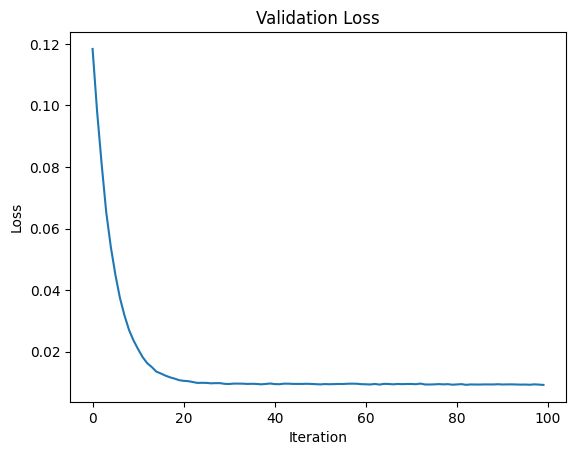

Text(0.5, 1.0, 'Training Loss')

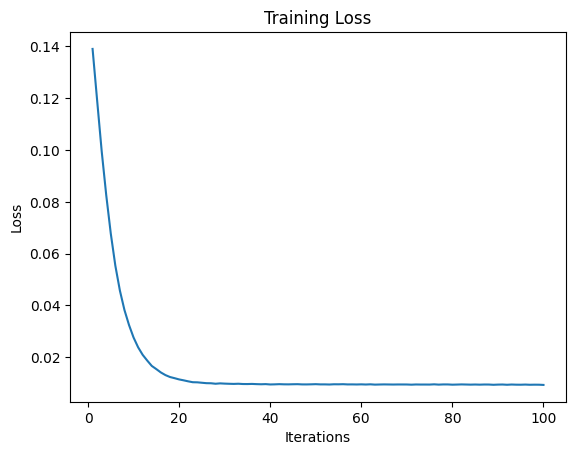

In [7]:
# plot validation loss
plt.plot(acccuracy_list)
plt.title('Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot the loss and validation loss

plt.plot(iteration_list, loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')



# Visualizing the NARMA10 dataset reconstructed by TDNN

In [8]:
# get prediction for training and validation
train_input_tensor = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train = tdnn(train_input_tensor)

valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
output_valid = tdnn(valid_input_tensor)

output_train.shape

torch.Size([4000, 1])

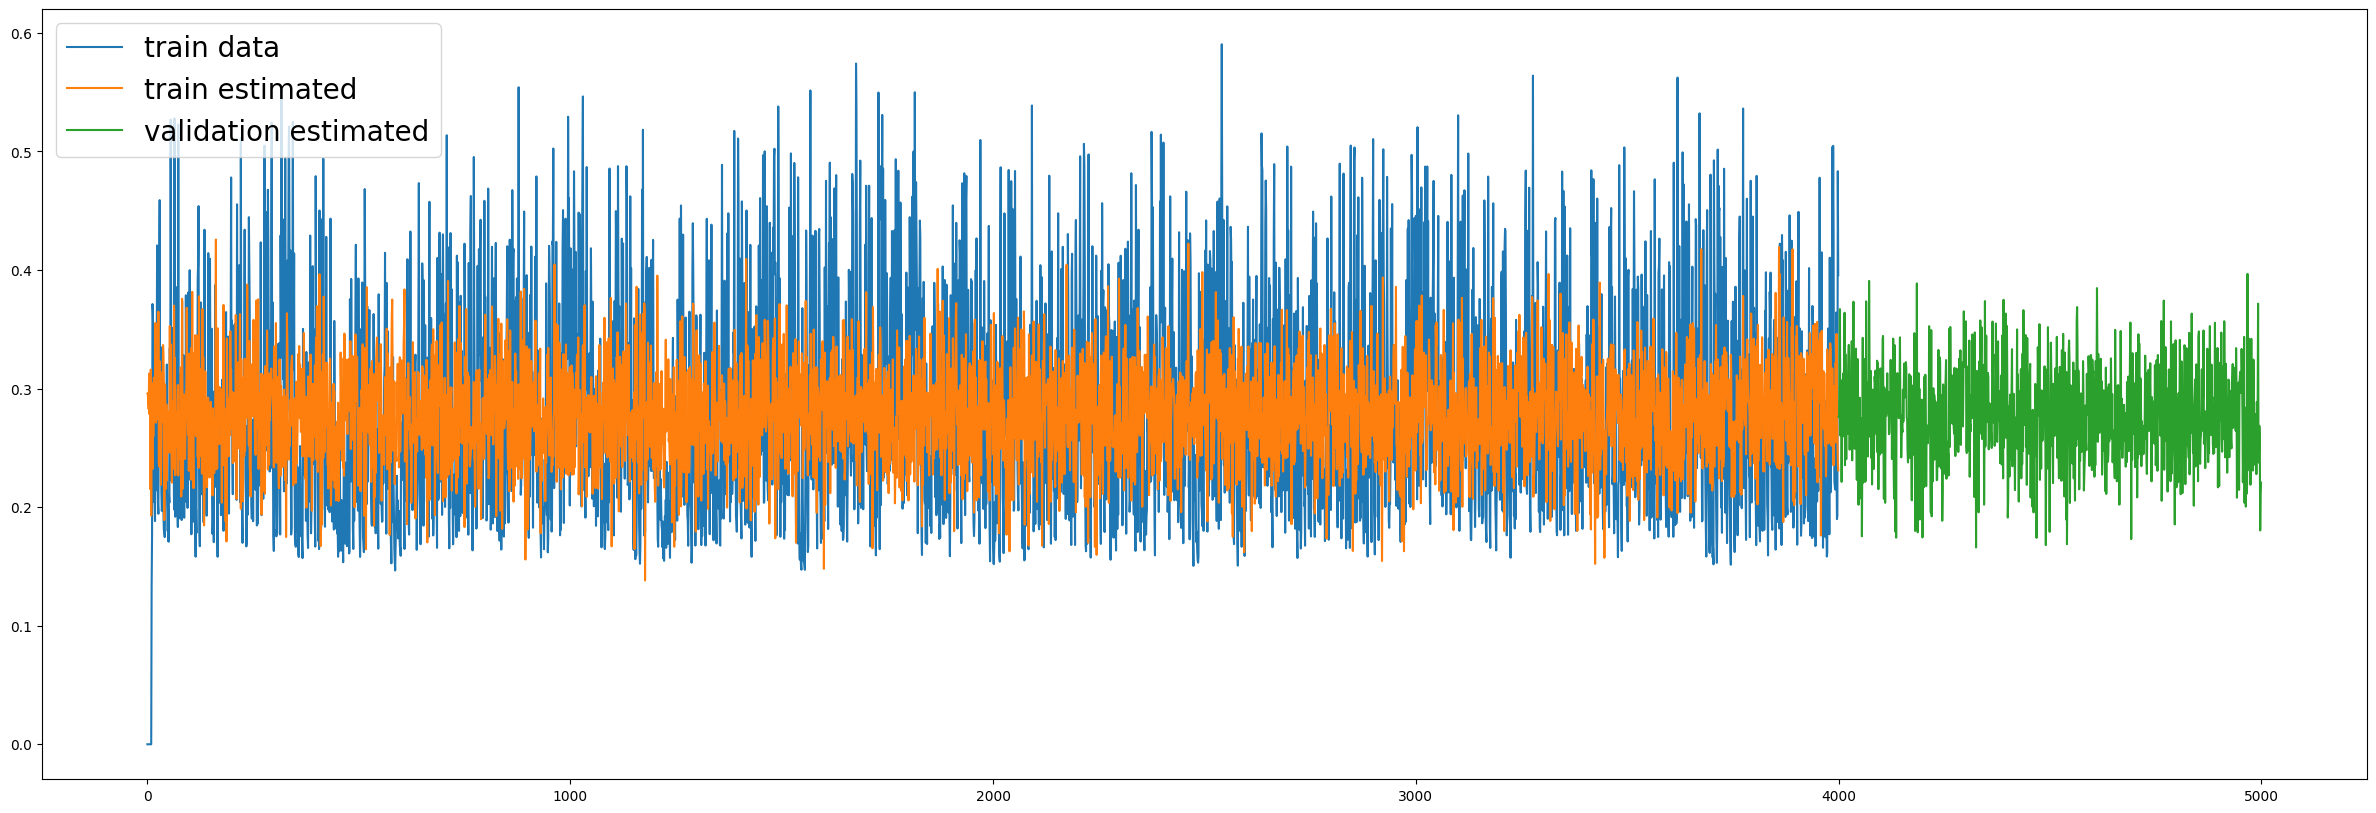

In [9]:

#get prediction for training input
input_train = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train = tdnn(input_train)
# detach the tensor
output_train = output_train.detach().numpy()
output_valid = output_valid.detach().numpy()
# converrt the tensor in the numpy array time series taking first only the time serie
#output_train = output_train.squeeze(2).detach().numpy()
# take the first element of the tensor
#output_train = output_train[:,1]

# figsize 30,10
plt.figure(figsize=(30,10))
# add ground truth for train output
plt.plot(train_output)
# add estimated output for train output
plt.plot(output_train)
# after 4000 step put the output_valid
plt.plot(np.arange(4000, 5000), output_valid[:,0])

plt.legend(['train data', 'train estimated', 'validation estimated'], loc='upper left', fontsize=20)

#output_train.shape

# Let's try RNN now

In [10]:
from RecurrentNeuralNetwork import *
from tqdm import tqdm

In [11]:
# get the copied data
train_input = train_input_copy
valid_input = valid_input_copy
test_input = test_input_copy

train_output = train_output_copy
valid_output = valid_output_copy
test_output = test_output_copy


In [12]:
rnn = RNN(
    input_size=1,
    hidden_size=100,
    output_size=1,
    num_layers=1
)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
loss = nn.MSELoss()

C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
# Training loop for RNN
num_epochs = 100
batch_size = 128
h_out = None
train_loss = []
valid_loss = []

for epoch in tqdm(range(num_epochs)):
    print(f'Epoch {epoch}')
    for i in range(0, len(train_input), batch_size):
        optimizer.zero_grad()
        
        input_batch = torch.Tensor(train_input[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
        output_batch = torch.Tensor(train_output[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
    
        output, h_out = rnn(input_batch, h_out)
        
        h_out = h_out.detach() if h_out is not None else None

        l = loss(output, output_batch)
        
        l.backward()
        optimizer.step()
        

    with torch.no_grad():
        
        valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
        output_valid, _ = rnn(valid_input_tensor, h_out)
        
        val_loss = loss(output_valid, torch.Tensor(valid_output.values).unsqueeze(1).unsqueeze(2))
        
        valid_loss.append(val_loss.item())
                
        train_loss.append(np.mean(l.item()))
        print(f'Validation Loss {val_loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


  1%|          | 1/100 [00:00<00:45,  2.20it/s]

Validation Loss 0.007648458704352379
Epoch 1


  2%|▏         | 2/100 [00:00<00:40,  2.44it/s]

Validation Loss 0.006609650328755379
Epoch 2


  3%|▎         | 3/100 [00:01<00:37,  2.56it/s]

Validation Loss 0.005917804315686226
Epoch 3


  4%|▍         | 4/100 [00:01<00:37,  2.59it/s]

Validation Loss 0.005206180736422539
Epoch 4


  5%|▌         | 5/100 [00:01<00:35,  2.66it/s]

Validation Loss 0.004746680147945881
Epoch 5


  6%|▌         | 6/100 [00:02<00:35,  2.63it/s]

Validation Loss 0.004551537334918976
Epoch 6


  7%|▋         | 7/100 [00:02<00:39,  2.33it/s]

Validation Loss 0.004501409363001585
Epoch 7


  8%|▊         | 8/100 [00:03<00:44,  2.08it/s]

Validation Loss 0.004487387835979462
Epoch 8


  9%|▉         | 9/100 [00:03<00:45,  1.99it/s]

Validation Loss 0.004477586597204208
Epoch 9


 10%|█         | 10/100 [00:04<00:44,  2.01it/s]

Validation Loss 0.004462141077965498
Epoch 10


 11%|█         | 11/100 [00:04<00:41,  2.16it/s]

Validation Loss 0.004459586925804615
Epoch 11


 12%|█▏        | 12/100 [00:05<00:40,  2.19it/s]

Validation Loss 0.004459579009562731
Epoch 12


 13%|█▎        | 13/100 [00:05<00:37,  2.30it/s]

Validation Loss 0.0044548120349645615
Epoch 13


 14%|█▍        | 14/100 [00:06<00:35,  2.39it/s]

Validation Loss 0.0044500273652374744
Epoch 14


 15%|█▌        | 15/100 [00:06<00:34,  2.45it/s]

Validation Loss 0.004441835917532444
Epoch 15


 16%|█▌        | 16/100 [00:06<00:33,  2.49it/s]

Validation Loss 0.004432853776961565
Epoch 16


 17%|█▋        | 17/100 [00:07<00:32,  2.53it/s]

Validation Loss 0.004423883277922869
Epoch 17


 18%|█▊        | 18/100 [00:07<00:32,  2.55it/s]

Validation Loss 0.004408594220876694
Epoch 18


 19%|█▉        | 19/100 [00:08<00:32,  2.51it/s]

Validation Loss 0.004385129548609257
Epoch 19


 20%|██        | 20/100 [00:08<00:31,  2.54it/s]

Validation Loss 0.004335589706897736
Epoch 20


 21%|██        | 21/100 [00:08<00:31,  2.55it/s]

Validation Loss 0.0042284405790269375
Epoch 21


 22%|██▏       | 22/100 [00:09<00:30,  2.57it/s]

Validation Loss 0.0039259884506464005
Epoch 22


 23%|██▎       | 23/100 [00:09<00:29,  2.57it/s]

Validation Loss 0.003745941910892725
Epoch 23


 24%|██▍       | 24/100 [00:09<00:29,  2.56it/s]

Validation Loss 0.0037178839556872845
Epoch 24


 25%|██▌       | 25/100 [00:10<00:30,  2.47it/s]

Validation Loss 0.0036957410629838705
Epoch 25


 26%|██▌       | 26/100 [00:11<00:34,  2.13it/s]

Validation Loss 0.0036816939245909452
Epoch 26


 27%|██▋       | 27/100 [00:11<00:36,  1.99it/s]

Validation Loss 0.0036415995564311743
Epoch 27


 28%|██▊       | 28/100 [00:12<00:36,  1.99it/s]

Validation Loss 0.0036362754181027412
Epoch 28


 29%|██▉       | 29/100 [00:12<00:33,  2.13it/s]

Validation Loss 0.00362971518188715
Epoch 29


 30%|███       | 30/100 [00:12<00:31,  2.25it/s]

Validation Loss 0.0035782752092927694
Epoch 30


 31%|███       | 31/100 [00:13<00:29,  2.32it/s]

Validation Loss 0.003322037635371089
Epoch 31


 32%|███▏      | 32/100 [00:13<00:29,  2.29it/s]

Validation Loss 0.0032859311904758215
Epoch 32


 33%|███▎      | 33/100 [00:14<00:27,  2.39it/s]

Validation Loss 0.003249169560149312
Epoch 33


 34%|███▍      | 34/100 [00:14<00:26,  2.45it/s]

Validation Loss 0.003230283735319972
Epoch 34


 35%|███▌      | 35/100 [00:14<00:26,  2.48it/s]

Validation Loss 0.0032154428772628307
Epoch 35


 36%|███▌      | 36/100 [00:15<00:25,  2.50it/s]

Validation Loss 0.003214959055185318
Epoch 36


 37%|███▋      | 37/100 [00:15<00:25,  2.50it/s]

Validation Loss 0.003192709758877754
Epoch 37


 38%|███▊      | 38/100 [00:16<00:24,  2.54it/s]

Validation Loss 0.00318339210934937
Epoch 38


 39%|███▉      | 39/100 [00:16<00:25,  2.42it/s]

Validation Loss 0.0032063110265880823
Epoch 39


 40%|████      | 40/100 [00:16<00:24,  2.45it/s]

Validation Loss 0.003141501685604453
Epoch 40


 41%|████      | 41/100 [00:17<00:23,  2.49it/s]

Validation Loss 0.003134895581752062
Epoch 41


 42%|████▏     | 42/100 [00:17<00:23,  2.51it/s]

Validation Loss 0.003109484910964966
Epoch 42


 43%|████▎     | 43/100 [00:18<00:22,  2.52it/s]

Validation Loss 0.0031090022530406713
Epoch 43


 44%|████▍     | 44/100 [00:18<00:22,  2.52it/s]

Validation Loss 0.003098878776654601
Epoch 44


 45%|████▌     | 45/100 [00:18<00:21,  2.54it/s]

Validation Loss 0.0030937858391553164
Epoch 45


 46%|████▌     | 46/100 [00:19<00:21,  2.47it/s]

Validation Loss 0.003085152944549918
Epoch 46


 47%|████▋     | 47/100 [00:19<00:21,  2.49it/s]

Validation Loss 0.003101954935118556
Epoch 47


 48%|████▊     | 48/100 [00:20<00:20,  2.51it/s]

Validation Loss 0.0030907236505299807
Epoch 48


 49%|████▉     | 49/100 [00:20<00:20,  2.51it/s]

Validation Loss 0.0031042220070958138
Epoch 49


 50%|█████     | 50/100 [00:20<00:19,  2.53it/s]

Validation Loss 0.003078935667872429
Epoch 50


 51%|█████     | 51/100 [00:21<00:19,  2.53it/s]

Validation Loss 0.0030904465820640326
Epoch 51


 52%|█████▏    | 52/100 [00:21<00:19,  2.52it/s]

Validation Loss 0.0030615769792348146
Epoch 52


 53%|█████▎    | 53/100 [00:22<00:19,  2.44it/s]

Validation Loss 0.0030807750299572945
Epoch 53


 54%|█████▍    | 54/100 [00:22<00:18,  2.45it/s]

Validation Loss 0.0030665872618556023
Epoch 54


 55%|█████▌    | 55/100 [00:22<00:18,  2.50it/s]

Validation Loss 0.0030476809479296207
Epoch 55


 56%|█████▌    | 56/100 [00:23<00:17,  2.53it/s]

Validation Loss 0.0030229000840336084
Epoch 56


 57%|█████▋    | 57/100 [00:23<00:16,  2.53it/s]

Validation Loss 0.0030002673156559467
Epoch 57


 58%|█████▊    | 58/100 [00:24<00:16,  2.56it/s]

Validation Loss 0.0029721048194915056
Epoch 58


 59%|█████▉    | 59/100 [00:24<00:15,  2.57it/s]

Validation Loss 0.002928064437583089
Epoch 59


 60%|██████    | 60/100 [00:24<00:16,  2.46it/s]

Validation Loss 0.0027600890025496483
Epoch 60


 61%|██████    | 61/100 [00:25<00:15,  2.51it/s]

Validation Loss 0.0022845049388706684
Epoch 61


 62%|██████▏   | 62/100 [00:25<00:14,  2.54it/s]

Validation Loss 0.001963274320587516
Epoch 62


 63%|██████▎   | 63/100 [00:26<00:14,  2.56it/s]

Validation Loss 0.002150509739294648
Epoch 63


 64%|██████▍   | 64/100 [00:26<00:14,  2.55it/s]

Validation Loss 0.0015737439971417189
Epoch 64


 65%|██████▌   | 65/100 [00:26<00:13,  2.53it/s]

Validation Loss 0.0014805479440838099
Epoch 65


 66%|██████▌   | 66/100 [00:27<00:13,  2.56it/s]

Validation Loss 0.0013996076304465532
Epoch 66


 67%|██████▋   | 67/100 [00:27<00:13,  2.46it/s]

Validation Loss 0.0014346326934173703
Epoch 67


 68%|██████▊   | 68/100 [00:28<00:12,  2.53it/s]

Validation Loss 0.0013747690245509148
Epoch 68


 69%|██████▉   | 69/100 [00:28<00:12,  2.57it/s]

Validation Loss 0.0013326304033398628
Epoch 69


 70%|███████   | 70/100 [00:28<00:11,  2.59it/s]

Validation Loss 0.0012678203638643026
Epoch 70


 71%|███████   | 71/100 [00:29<00:11,  2.61it/s]

Validation Loss 0.00128836533986032
Epoch 71


 72%|███████▏  | 72/100 [00:29<00:10,  2.62it/s]

Validation Loss 0.0013701798161491752
Epoch 72


 73%|███████▎  | 73/100 [00:29<00:10,  2.61it/s]

Validation Loss 0.001275649992749095
Epoch 73


 74%|███████▍  | 74/100 [00:30<00:10,  2.53it/s]

Validation Loss 0.0011669707018882036
Epoch 74


 75%|███████▌  | 75/100 [00:30<00:09,  2.56it/s]

Validation Loss 0.0011116205714643002
Epoch 75


 76%|███████▌  | 76/100 [00:31<00:09,  2.59it/s]

Validation Loss 0.0010769916698336601
Epoch 76


 77%|███████▋  | 77/100 [00:31<00:08,  2.61it/s]

Validation Loss 0.0010387563379481435
Epoch 77


 78%|███████▊  | 78/100 [00:31<00:08,  2.63it/s]

Validation Loss 0.0010143191320821643
Epoch 78


 79%|███████▉  | 79/100 [00:32<00:07,  2.64it/s]

Validation Loss 0.0009795187506824732
Epoch 79


 80%|████████  | 80/100 [00:32<00:07,  2.65it/s]

Validation Loss 0.0009393874206580222
Epoch 80


 81%|████████  | 81/100 [00:33<00:07,  2.57it/s]

Validation Loss 0.0008937626844272017
Epoch 81


 82%|████████▏ | 82/100 [00:33<00:06,  2.59it/s]

Validation Loss 0.0008644208428449929
Epoch 82


 83%|████████▎ | 83/100 [00:33<00:06,  2.62it/s]

Validation Loss 0.0008192292298190296
Epoch 83


 84%|████████▍ | 84/100 [00:34<00:06,  2.63it/s]

Validation Loss 0.0007816054276190698
Epoch 84


 85%|████████▌ | 85/100 [00:34<00:05,  2.63it/s]

Validation Loss 0.0007827492081560194
Epoch 85


 86%|████████▌ | 86/100 [00:34<00:05,  2.63it/s]

Validation Loss 0.0007778404979035258
Epoch 86


 87%|████████▋ | 87/100 [00:35<00:05,  2.55it/s]

Validation Loss 0.0007304729078896344
Epoch 87


 88%|████████▊ | 88/100 [00:35<00:04,  2.59it/s]

Validation Loss 0.0006427096668630838
Epoch 88


 89%|████████▉ | 89/100 [00:36<00:04,  2.59it/s]

Validation Loss 0.0006395320524461567
Epoch 89


 90%|█████████ | 90/100 [00:36<00:03,  2.61it/s]

Validation Loss 0.0005939910188317299
Epoch 90


 91%|█████████ | 91/100 [00:36<00:03,  2.61it/s]

Validation Loss 0.0005438877851702273
Epoch 91


 92%|█████████▏| 92/100 [00:37<00:03,  2.62it/s]

Validation Loss 0.0004981740494258702
Epoch 92


 93%|█████████▎| 93/100 [00:37<00:02,  2.59it/s]

Validation Loss 0.0004537880595307797
Epoch 93


 94%|█████████▍| 94/100 [00:38<00:02,  2.53it/s]

Validation Loss 0.0003646274271886796
Epoch 94


 95%|█████████▌| 95/100 [00:38<00:02,  2.46it/s]

Validation Loss 0.00032879607169888914
Epoch 95


 96%|█████████▌| 96/100 [00:38<00:01,  2.51it/s]

Validation Loss 0.0003052961837965995
Epoch 96


 97%|█████████▋| 97/100 [00:39<00:01,  2.56it/s]

Validation Loss 0.00030784413684159517
Epoch 97


 98%|█████████▊| 98/100 [00:39<00:00,  2.43it/s]

Validation Loss 0.00021385704167187214
Epoch 98


 99%|█████████▉| 99/100 [00:40<00:00,  2.43it/s]

Validation Loss 0.0002754449669737369
Epoch 99


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]

Validation Loss 0.00031454121926799417


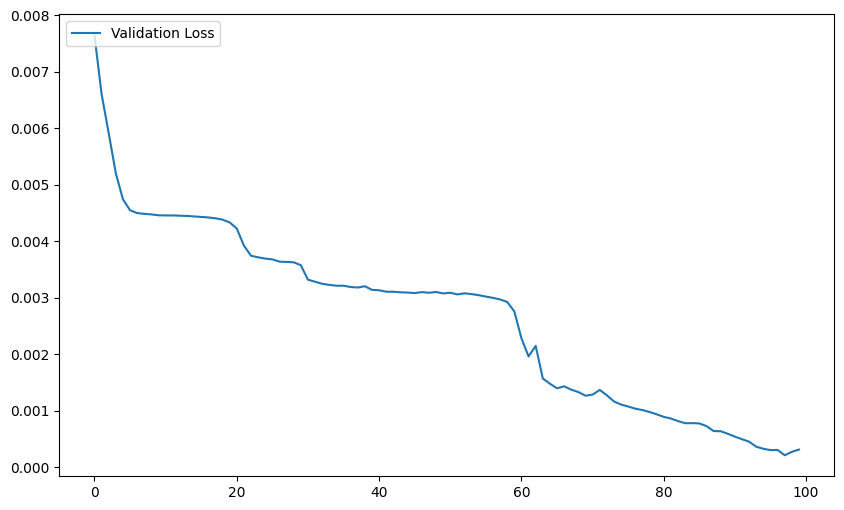

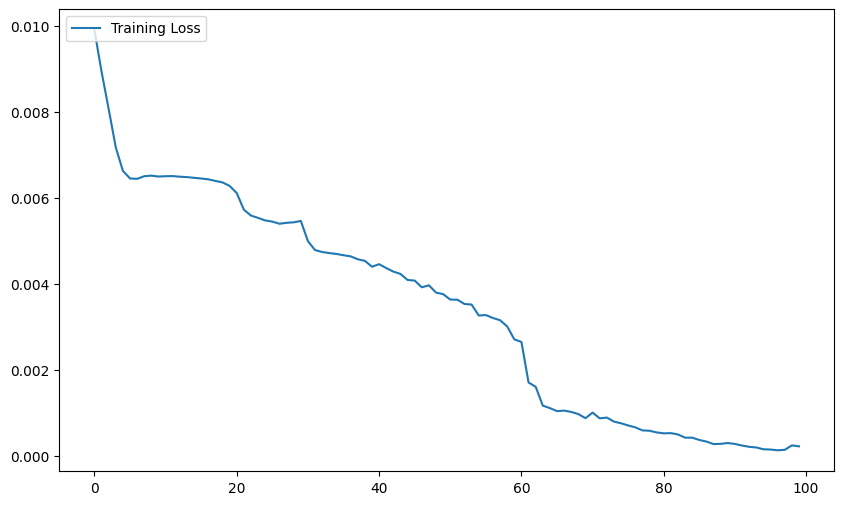

In [14]:
# Show curves validation and training
plt.figure(figsize=(10,6))
plt.plot(valid_loss)
plt.legend(['Validation Loss'], loc='upper left', fontsize=10)

# plot the training loss
plt.figure(figsize=(10,6))
plt.plot(train_loss)
plt.legend(['Training Loss'], loc='upper left', fontsize=10)



# Visualizing the NARMA10 dataset reconstructed by RNN

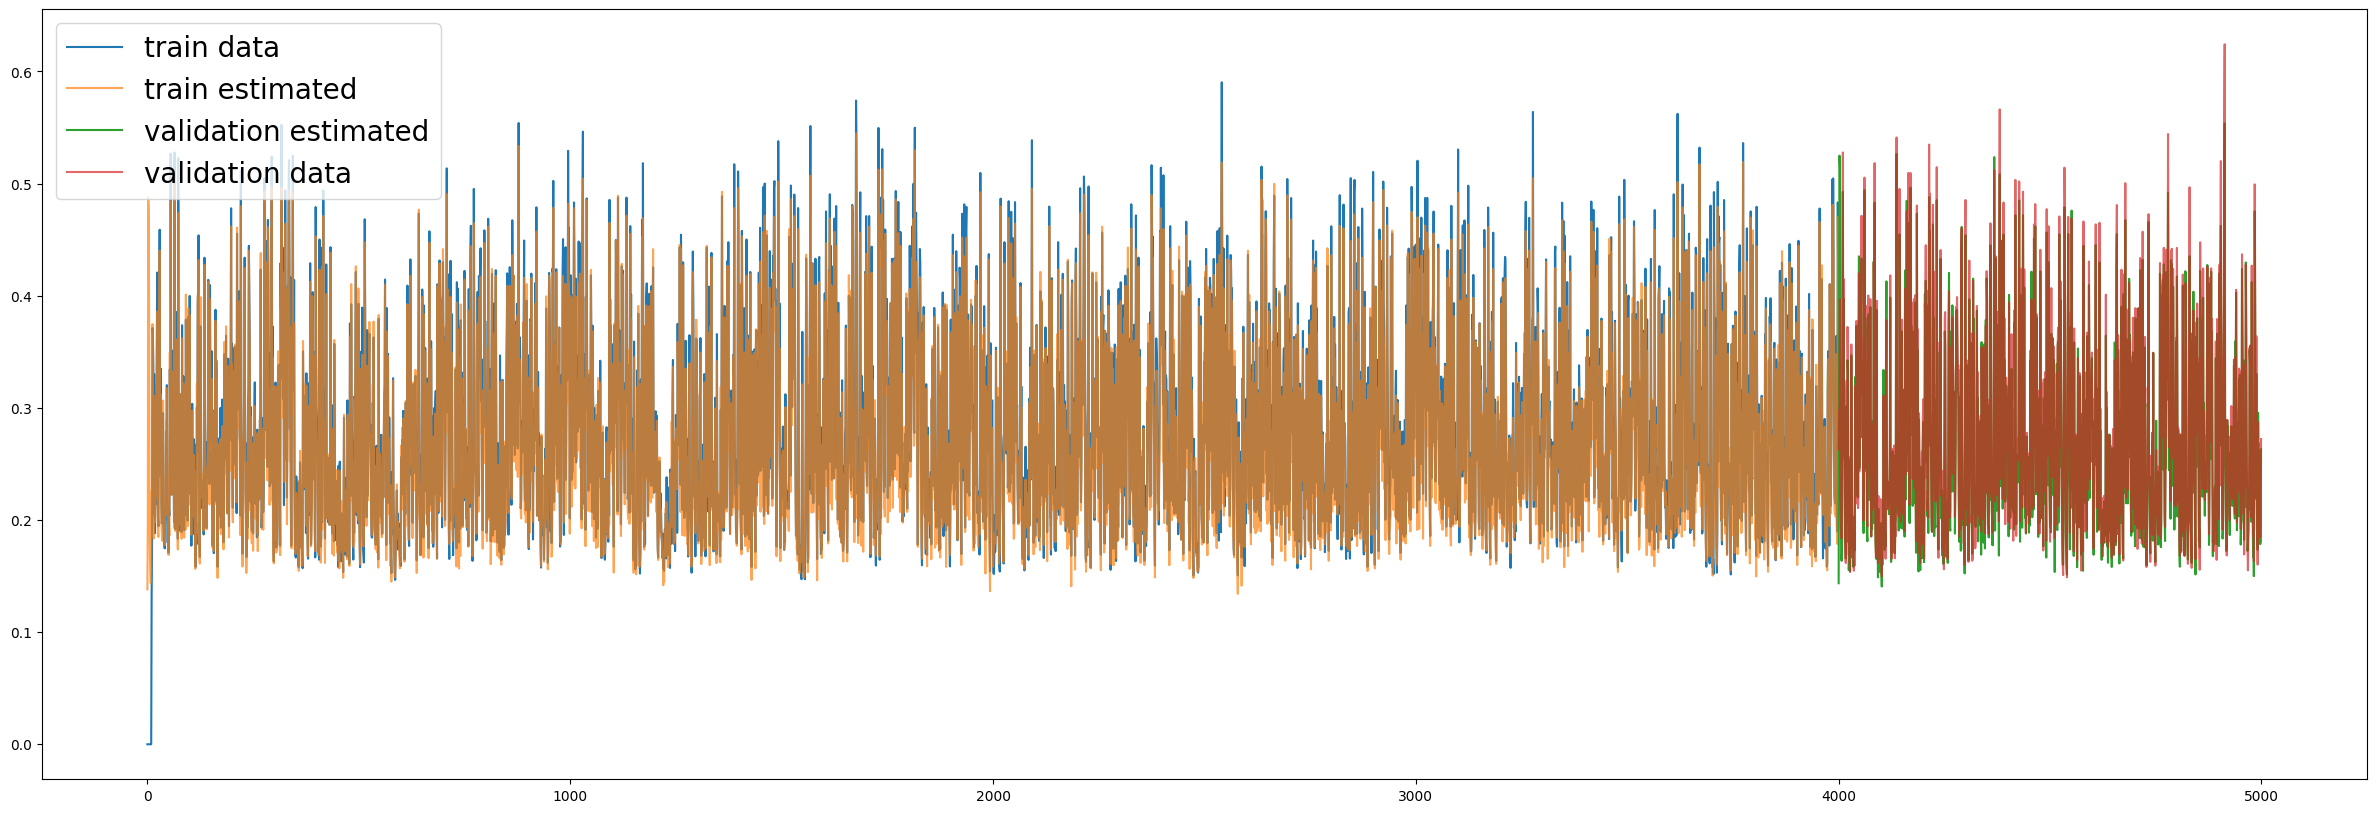

In [15]:
# get prediction for training and validation
train_input_tensor = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train, _ = rnn(train_input_tensor)

valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
output_valid, _ = rnn(valid_input_tensor)

# detach the tensor
output_train = output_train.detach().numpy()
output_valid = output_valid.detach().numpy()

# figsize 30,10
plt.figure(figsize=(30,10))
# add ground truth for train output
plt.plot(train_output)
# add estimated output for train output
# plot only the first of the tensor
plt.plot(output_train[:,0], alpha=0.7)
# after 4000 step put the output_valid
plt.plot(np.arange(4000, 5000), output_valid[:,0])
# plot output to see if valid is correct
plt.plot(valid_output, alpha=0.7)
plt.legend(['train data', 'train estimated', 'validation estimated', 'validation data'], loc='upper left', fontsize=20)